<a href="https://colab.research.google.com/github/rpandyaiit7509/Machine_Translation/blob/main/English_to_kannada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports & Hyperparameters

In [1]:
import torch
import torch.nn as nn
import numpy as np

# Hyperparameters Configuration

d_model = 16            # Dimension of model (hidden size for embeddings and layers)
n_heads = 2             # Number of attention heads in Multi-Head Attention
d_ff = 32               # Dimension of feedforward layer inside Transformer block
max_seq_len = 40        # Maximum length of input/output sequence
vocab_size_en = 12      # Size of English vocabulary (input language)
vocab_size_ka = 12      # Size of Kannada vocabulary (target language)
learning_rate = 0.001   # Starting learning rate for optimizer
warmup_steps = 400      # Steps for learning rate warm-up schedule, defines the number of warm-up steps during training, and its function is to gradually increase the learning rate from a small value to the target (or base) learning rate over the first 400 steps of training.
epochs = 1000           # Number of training epochs
label_smoothing = 0.1   # Amount of smoothing in cross-entropy loss to prevent overfitting




##Attention Mechanism

Scaled Dot-Product Attention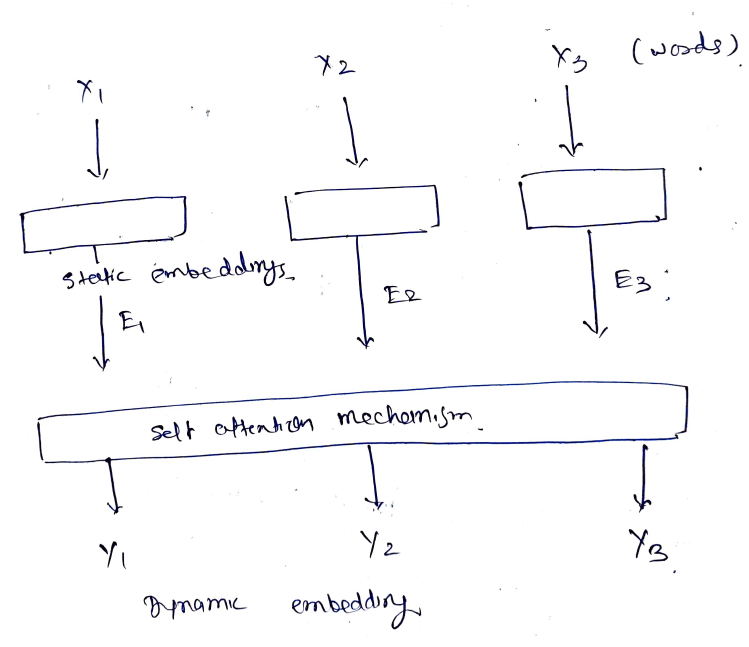





The attention mechanism computes attention using the following formula:

\begin{equation}
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^\top}{\sqrt{d_k}} \right) V
\end{equation}






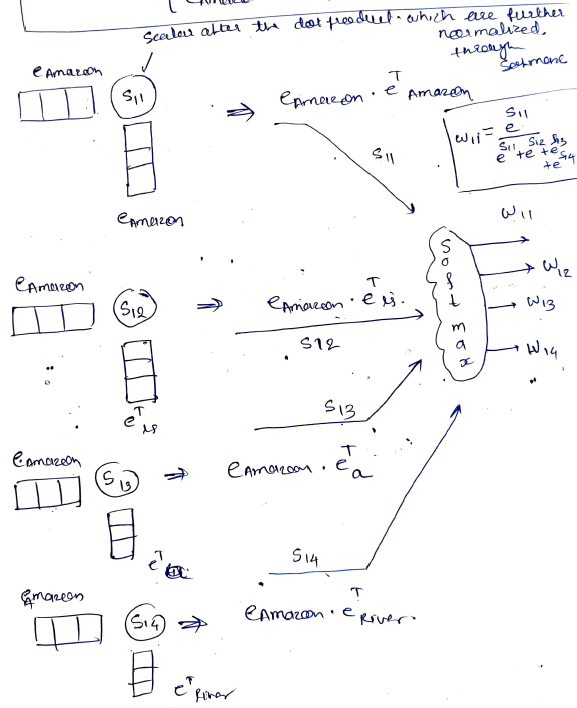

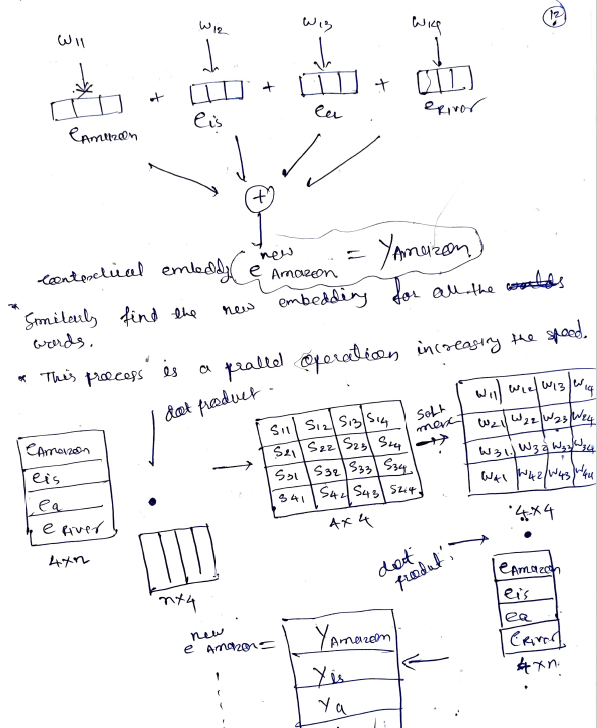

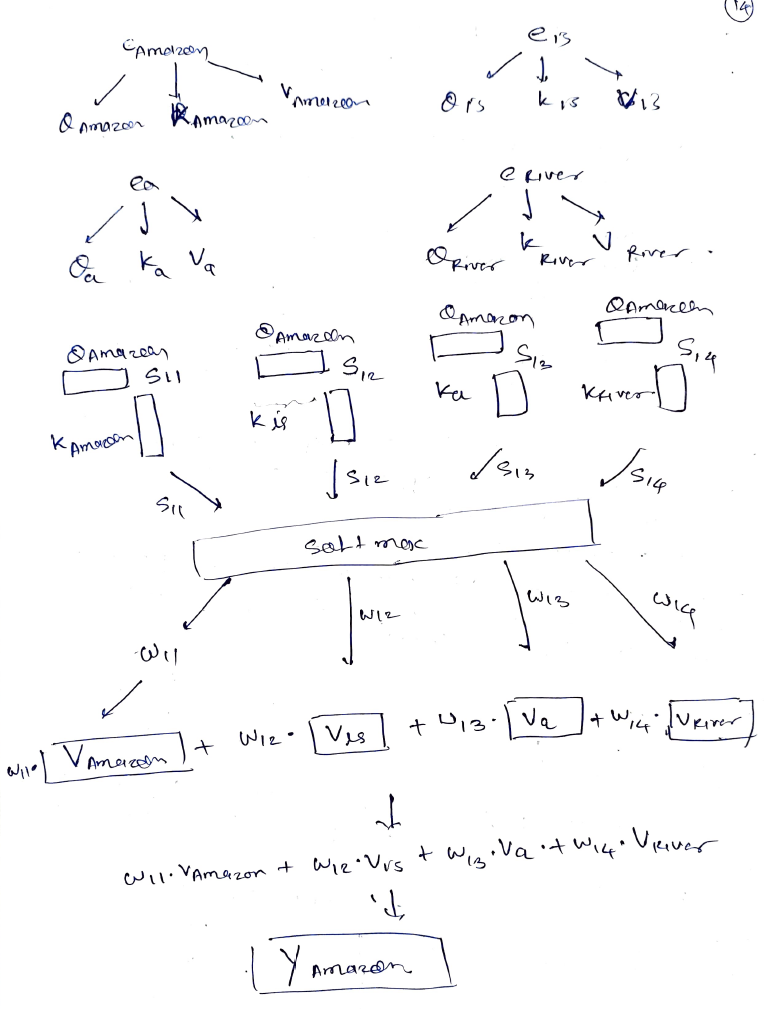

In [2]:
# Scaled Dot-Product Attention

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()  # Initialize the parent class (nn.Module)

    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)  # Get the dimensionality of the query vectors (last dimension)

        # Compute the raw attention scores by taking the dot product of Q and K^T,
        # then scale by the square root of d_k for numerical stability
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

        # If a mask is provided (e.g., to ignore certain positions like padding),
        # replace those positions with a very large negative value so their softmax becomes ~0
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax to obtain normalized attention weights
        attention_weights = torch.softmax(scores, dim=-1)

        # Multiply the attention weights with the value matrix V to get the final output
        output = torch.matmul(attention_weights, V)

        # Return both the output and the attention weights (for analysis or visualization)
        return output, attention_weights


##Multi-Head Attention


*  Splits the embedding space into  Q, K, V are projected into subspaces.
*   Attention is applied per head.
*   Results are concatenated and linearly transformed.

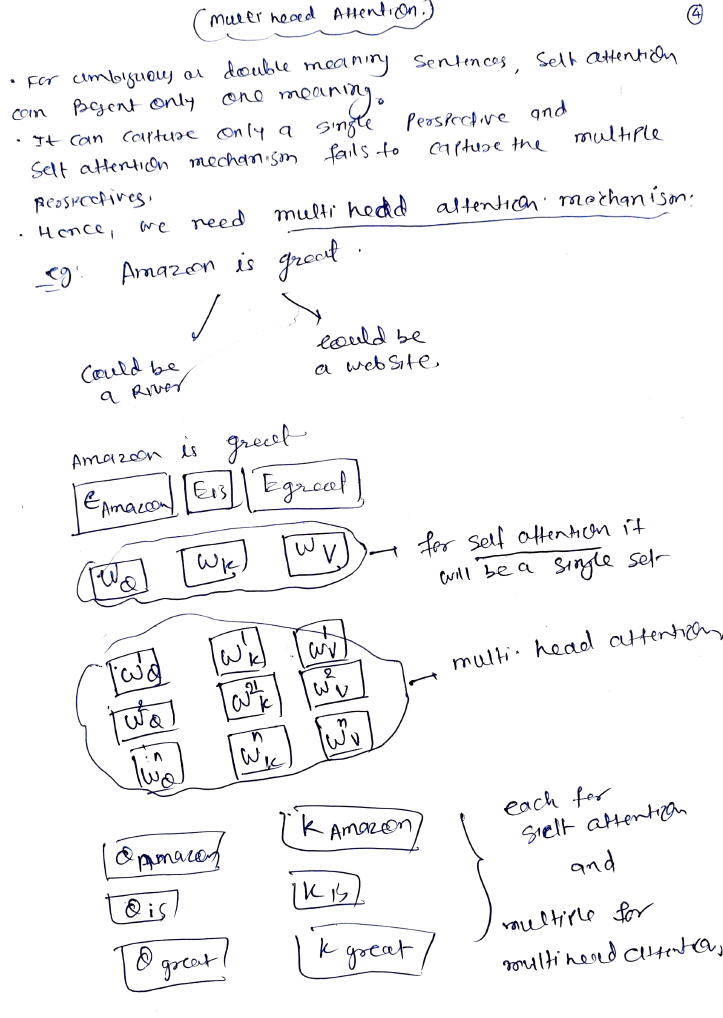

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.d_model = d_model                # Total dimensionality of the model
        self.n_heads = n_heads                # Number of attention heads
        self.d_k = d_model // n_heads         # Dimensionality of each head (must divide evenly)

        # Linear projections for queries, keys, and values (one for each input type)
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Linear layer to combine the output from all heads
        self.W_o = nn.Linear(d_model, d_model)

        # Scaled dot-product attention module (shared across heads)
        self.attention = ScaledDotProductAttention()

        # Initialize weights using Xavier initialization for better training stability
        nn.init.xavier_uniform_(self.W_q.weight)
        nn.init.xavier_uniform_(self.W_k.weight)
        nn.init.xavier_uniform_(self.W_v.weight)
        nn.init.xavier_uniform_(self.W_o.weight)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)  # Get the batch size

        # Project Q, K, V and reshape to (batch_size, n_heads, seq_len, d_k)
        Q = self.W_q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)

        # Apply scaled dot-product attention on each head in parallel
        output, attn_weights = self.attention(Q, K, V, mask)

        # Concatenate all the heads' outputs and reshape to (batch_size, seq_len, d_model)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # Final linear layer to project back to d_model dimensions
        return self.W_o(output)


# Feed-Forward Network

In [4]:
# Feed-Forward Network (Position-wise Feed-Forward Layer used in Transformer blocks)
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()

        # First linear layer projects from d_model to d_ff (hidden layer dimension)
        self.linear1 = nn.Linear(d_model, d_ff)

        # Second linear layer projects back from d_ff to d_model
        self.linear2 = nn.Linear(d_ff, d_model)

        # Initialize both linear layers using Xavier initialization for better convergence
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)

        # ReLU activation function for non-linearity
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply linear1 -> ReLU -> linear2 in sequence
        return self.linear2(self.relu(self.linear1(x)))


## Positional Encoding and Layer Normalization


##Positional Encoding

* Adds position information to token embeddings using sine (even indices) and cosine (odd indices) functions:
*   Helps Transformer understand the order of tokens.
*   Generates a fixed pattern based on position and model dimension.


## Layer Normalization
*   Makes training more stable.

\\begin{equation}
\text{LayerNorm}(x) = \gamma \cdot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
\end{equation}

*   γ and β are learnable parameters (scale and shift)




In [5]:

# Positional encoding for sequence positions
def positional_encoding(max_seq_len, d_model):
    # Create a matrix of zeros to hold positional encodings
    pe = torch.zeros(max_seq_len, d_model)

    # Create a tensor of shape (max_seq_len, 1) with position indices [0, 1, 2, ..., max_seq_len-1]
    position = torch.arange(0, max_seq_len, dtype=torch.float32).unsqueeze(1)

    # Compute the denominator term for sine and cosine (logarithmic scale frequencies)
    div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0) / d_model))

    # Apply sine to even indices (0, 2, 4, ...)
    pe[:, 0::2] = torch.sin(position * div_term)

    # Apply cosine to odd indices (1, 3, 5, ...)
    pe[:, 1::2] = torch.cos(position * div_term)

    # Return the positional encoding matrix of shape (max_seq_len, d_model)
    return pe


# Custom Layer Normalization
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon=1e-6):
        super().__init__()

        # Learnable scale parameter initialized to 1s
        self.gamma = nn.Parameter(torch.ones(d_model))

        # Learnable shift parameter initialized to 0s
        self.beta = nn.Parameter(torch.zeros(d_model))

        # Small value to avoid division by zero in normalization
        self.epsilon = epsilon

    def forward(self, x):
        # Compute the mean across the last dimension
        mean = x.mean(dim=-1, keepdim=True)

        # Compute the standard deviation across the last dimension
        std = x.std(dim=-1, keepdim=True)

        # Normalize the input, then scale and shift using gamma and beta
        return self.gamma * (x - mean) / (std + self.epsilon) + self.beta

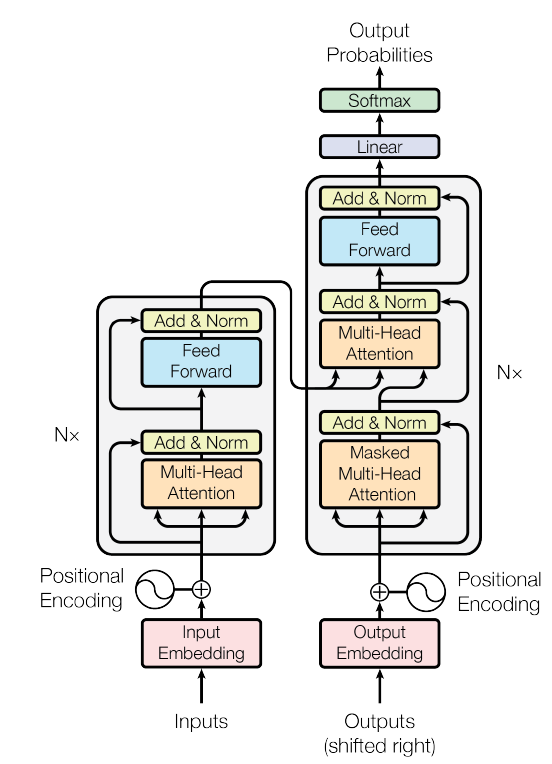# Transformer Encoder Layer


In [6]:
# Single layer of Transformer Encoder
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()

        # Multi-head self-attention layer
        self.mha = MultiHeadAttention(d_model, n_heads)

        # Position-wise feed-forward network
        self.ffn = FeedForward(d_model, d_ff)

        # Layer normalization after attention sub-layer
        self.norm1 = LayerNorm(d_model)

        # Layer normalization after feed-forward sub-layer
        self.norm2 = LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Apply multi-head self-attention (Q=K=V=x for self-attention)
        attn_output = self.mha(x, x, x, mask)

        # Add & Norm: residual connection + layer normalization
        x = self.norm1(x + attn_output)

        # Apply position-wise feed-forward network
        ffn_output = self.ffn(x)

        # Add & Norm: residual connection + layer normalization
        x = self.norm2(x + ffn_output)

        # Output of the encoder layer
        return x


# Transformer Decoder Layer

In [7]:
# Single layer of Transformer Decoder
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()

        # First Multi-Head Attention: masked self-attention for the target sequence
        self.mha1 = MultiHeadAttention(d_model, n_heads)

        # Second Multi-Head Attention: encoder-decoder attention (cross-attention)
        self.mha2 = MultiHeadAttention(d_model, n_heads)

        # Feed-forward network applied after attention blocks
        self.ffn = FeedForward(d_model, d_ff)

        # Layer normalizations after each sub-layer
        self.norm1 = LayerNorm(d_model)  # After self-attention
        self.norm2 = LayerNorm(d_model)  # After encoder-decoder attention
        self.norm3 = LayerNorm(d_model)  # After feed-forward network

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        # Step 1: Masked self-attention on the decoder input
        # (prevents the decoder from seeing future tokens)
        attn1 = self.mha1(x, x, x, tgt_mask)

        # Add & Norm after self-attention
        x = self.norm1(x + attn1)

        # Step 2: Encoder-decoder (cross) attention
        # Queries come from decoder, Keys and Values from encoder output
        attn2 = self.mha2(x, enc_output, enc_output, src_mask)

        # Add & Norm after cross-attention
        x = self.norm2(x + attn2)

        # Step 3: Position-wise feed-forward network
        ffn_output = self.ffn(x)

        # Add & Norm after FFN
        x = self.norm3(x + ffn_output)

        # Return the output of the decoder layer
        return x


# Transformer Model

In [8]:
# Define the Transformer model class
class Transformer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, max_seq_len, vocab_size_en, vocab_size_ka):
        super().__init__()  # Initialize the parent nn.Module class

        # Encoder layer with multi-head attention and feed-forward
        self.encoder = EncoderLayer(d_model, n_heads, d_ff)

        # Decoder layer with masked multi-head attention, encoder-decoder attention, and feed-forward
        self.decoder = DecoderLayer(d_model, n_heads, d_ff)

        # Positional encoding to capture word order information
        self.pos_enc = positional_encoding(max_seq_len, d_model)

        # Embedding layer for English input tokens
        self.embedding_en = nn.Embedding(vocab_size_en, d_model)

        # Embedding layer for Kannada target tokens
        self.embedding_ka = nn.Embedding(vocab_size_ka, d_model)

        # Output linear layer to project decoder output to vocabulary size
        self.output_layer = nn.Linear(d_model, vocab_size_ka)

        # Initialize embedding and output weights using Xavier uniform for better convergence
        nn.init.xavier_uniform_(self.embedding_en.weight)
        nn.init.xavier_uniform_(self.embedding_ka.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        # Apply embedding and positional encoding to source sequence
        src_emb = self.embedding_en(src) + self.pos_enc[:src.size(1), :].to(src.device)

        # Apply embedding and positional encoding to target sequence
        tgt_emb = self.embedding_ka(tgt) + self.pos_enc[:tgt.size(1), :].to(tgt.device)

        # Pass through encoder with optional source mask
        enc_output = self.encoder(src_emb, src_mask)

        # Pass through decoder with encoder output and optional masks
        dec_output = self.decoder(tgt_emb, enc_output, src_mask, tgt_mask)

        # Apply output linear layer to get logits over Kannada vocabulary
        return self.output_layer(dec_output)


In [9]:
# Create padding mask to avoid attending to <PAD> tokens (usually ID = 0)
def create_padding_mask(seq, pad_id=0):
    # Create a mask where True (1) indicates non-pad tokens and False (0) indicates pad tokens
    # Shape: (batch_size, seq_len)
    mask = (seq != pad_id)

    # Unsqueeze to shape (batch_size, 1, 1, seq_len) to broadcast correctly in attention computation
    return mask.unsqueeze(1).unsqueeze(2).long()
    # This ensures that attention doesn't consider pad tokens during attention scoring


# Create a causal mask to prevent decoder from looking ahead (future positions)
def create_causal_mask(seq_len):
    # Create a lower triangular matrix (1s in lower triangle, 0s elsewhere)
    # This allows each position to attend only to itself and previous positions
    mask = torch.tril(torch.ones(seq_len, seq_len))

    # Add batch and head dimensions for broadcasting during attention
    return mask.unsqueeze(0).unsqueeze(1)
    # Shape: (1, 1, seq_len, seq_len) to be used with decoder self-attention



##Synthetic Vocabulary and Dataset

In [10]:
# English vocabulary with word to index mapping
vocab_en = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "i": 3, "go": 4, "to": 5, "school": 6, "read": 7, "book": 8, "we": 9, "eat": 10, "food": 11}

# Kannada vocabulary with word to index mapping
vocab_ka = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "naanu": 3, "hoguttene": 4, "ge": 5, "shale": 6, "oduttene": 7, "pustaka": 8, "naavu": 9, "tinnuttene": 10, "ahara": 11}

# Parallel English–Kannada sentence pairs encoded as token IDs
data = [
    ([1, 3, 4, 5, 6, 2], [1, 3, 5, 6, 4, 2]),  # "i go to school" -> "naanu ge shale hoguttene"
    ([1, 3, 7, 8, 2], [1, 3, 8, 7, 2]),        # "i read book" -> "naanu pustaka oduttene"
    ([1, 9, 10, 11, 2], [1, 9, 11, 10, 2]),    # "we eat food" -> "naavu ahara tinnuttene"
    ([1, 3, 10, 11, 2], [1, 3, 11, 10, 2]),    # "i eat food" -> "naanu ahara tinnuttene"
    ([1, 9, 4, 5, 6, 2], [1, 9, 5, 6, 4, 2]),  # "we go to school" -> "naavu ge shale hoguttene"
    ([1, 3, 7, 5, 6, 2], [1, 3, 5, 6, 7, 2]),  # "i read to school" -> "naanu ge shale oduttene"
    ([1, 9, 7, 8, 2], [1, 9, 8, 7, 2]),        # "we read book" -> "naavu pustaka oduttene"
    ([1, 3, 4, 8, 2], [1, 3, 8, 4, 2]),        # "i go book" -> "naanu pustaka hoguttene"
    ([1, 9, 7, 5, 6, 2], [1, 9, 5, 6, 7, 2]),  # "we read to school" -> "naavu ge shale oduttene"
]


##Cross-Entropy Loss with Label Smoothing

In [11]:
# Custom loss function using label smoothing to improve generalization
class CrossEntropyLossWithSmoothing(nn.Module):
    def __init__(self, vocab_size, smoothing=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.smoothing = smoothing

    def forward(self, output, target):
        output = output.view(-1, self.vocab_size)     # Reshape output to (batch*seq_len, vocab_size)
        target = target.view(-1)                      # Flatten target to (batch*seq_len)
        log_probs = torch.log_softmax(output, dim=-1) # Compute log softmax probabilities

        # Set smoothing values (confidence for correct class and small probability for others)
        confidence = 1 - self.smoothing
        label_smoothed = torch.full_like(log_probs, self.smoothing / (self.vocab_size - 1))

        # Replace correct class probabilities with confidence
        label_smoothed.scatter_(1, target.unsqueeze(1), confidence)

        # Ignore loss where target is padding
        label_smoothed[target == 0] = 0

        # Compute cross-entropy between smoothed labels and log probabilities
        return -torch.mean(torch.sum(label_smoothed * log_probs, dim=-1))


###Learning Rate Scheduler for Transformer

In [12]:
# Learning rate scheduler based on Transformer warm-up formula from "Attention is All You Need"
#Purpose of Learning Rate Scheduler
#The scheduler adjusts the learning rate at each step or epoch, usually to:
#Warm up (gradually increase) the learning rate at the start to prevent unstable updates.
#Decay (gradually decrease) it later so the model can converge smoothly and fine-tune weights.

class TransformerScheduler:
    def __init__(self, optimizer, d_model, warmup_steps):
        self.optimizer = optimizer       # Optimizer (e.g., Adam) whose LR will be updated
        self.d_model = d_model           # Model dimensionality (used in scaling the LR)
        self.warmup_steps = warmup_steps  # Number of steps to increase LR during warm-up
        self.step_num = 0                # Counter to track the number of optimization steps

    def step(self):
        self.step_num += 1  # Increment the step count

        # Compute learning rate based on:
        # (1) Inverse square root of step number (after warm-up)
        # (2) Linear increase during warm-up steps
        # Final formula: (d_model)^(-0.5) * min(step_num^(-0.5), step_num * (warmup_steps)^(-1.5))
        lr = (self.d_model ** -0.5) * min(self.step_num ** -0.5, self.step_num * self.warmup_steps ** -1.5)

        # Update learning rate in the optimizer
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        # Return the current learning rate (optional for logging/monitoring)
        return lr


###Training Loop

In [13]:
# Initialize Transformer model with hyperparameters and vocabulary sizes
model = Transformer(d_model, n_heads, d_ff, max_seq_len, len(vocab_en), len(vocab_ka))

# Adam optimizer with parameters recommended in the original Transformer paper
#Function of Adam Optimizer. It updates the weights of the neural network during training to minimize the loss function by combining the advantages of two other optimizers:

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

# Custom learning rate scheduler based on warm-up strategy
scheduler = TransformerScheduler(optimizer, d_model, warmup_steps)

# Loss function with label smoothing to improve generalization
criterion = CrossEntropyLossWithSmoothing(vocab_size_ka, label_smoothing)

# Training function
def train(model, data, epochs):
    model.train()  # Set model to training mode (enable dropout, etc.)

    for epoch in range(epochs):
        total_loss = 0

        for src, tgt in data:
            # Convert input sequences to PyTorch tensors
            src = torch.tensor([src], dtype=torch.long)

            # Prepare decoder input by removing the <eos> token (last token)
            tgt_in = torch.tensor([tgt[:-1]], dtype=torch.long)

            # Prepare decoder target by removing the <sos> token (first token)
            tgt_out = torch.tensor([tgt[1:]], dtype=torch.long)

            # Create masks:
            # src_mask: masks out padding tokens in source sequence
            src_mask = create_padding_mask(src)

            # tgt_mask: masks future positions for autoregressive decoding
            tgt_mask = create_causal_mask(tgt_in.size(1))

            # Zero gradients before backpropagation
            optimizer.zero_grad()

            # Forward pass through the model with masks
            output = model(src, tgt_in, src_mask, tgt_mask)

            # Calculate loss between model output and expected output
            loss = criterion(output, tgt_out)

            # Backpropagation
            loss.backward()

            # Gradient clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update model parameters
            optimizer.step()

            # Update learning rate according to scheduler
            scheduler.step()

            # Accumulate loss for reporting
            total_loss += loss.item()

        # Print average loss every 100 epochs for monitoring training progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss / len(data):.4f}")

# Start training loop
train(model, data, epochs)


Epoch 0, Loss: 2.8711
Epoch 100, Loss: 0.5651
Epoch 200, Loss: 0.5650
Epoch 300, Loss: 0.5649
Epoch 400, Loss: 0.5649
Epoch 500, Loss: 0.5649
Epoch 600, Loss: 0.5649
Epoch 700, Loss: 0.5649
Epoch 800, Loss: 0.5649
Epoch 900, Loss: 0.5649


## Translation function from English to Kannada

In [14]:
# Translation function from English to Kannada using the trained Transformer model
def translate(model, sentence, vocab_en, vocab_ka, max_len=10):
    model.eval()  # Set model to evaluation mode (disable dropout, etc.)

    # Create inverse vocabulary to map IDs back to words in Kannada
    inv_vocab_ka = {v: k for k, v in vocab_ka.items()}

    # Tokenize input sentence, add start-of-sequence (<sos>) and end-of-sequence (<eos>) tokens
    tokens = ["<sos>"] + sentence.lower().split() + ["<eos>"]

    # Convert tokens to their corresponding IDs, use 0 (usually <pad>) if token not found in vocab_en
    src = [vocab_en.get(t, 0) for t in tokens]

    # Pad the source sequence to max_len with zeros (padding token)
    src = torch.tensor([src + [0] * (max_len - len(src))], dtype=torch.long)

    # Create source mask to ignore padded tokens during attention
    src_mask = create_padding_mask(src)

    # Initialize target sequence with <sos> token followed by padding
    tgt = torch.tensor([[vocab_ka["<sos>"]] + [0] * (max_len - 1)], dtype=torch.long)

    # Autoregressive decoding loop: predict tokens one-by-one until max_len or <eos> token generated
    for i in range(max_len - 1):
        # Create causal mask so decoder can't attend to future tokens beyond position i
        tgt_mask = create_causal_mask(i + 1)

        with torch.no_grad():  # Disable gradient calculation during inference
            # Forward pass: model predicts next token probabilities given current src and tgt tokens
            output = model(src, tgt[:, :i + 1], src_mask, tgt_mask)

        # Select the token with highest probability at the current position i
        next_token = output[0, i, :].argmax().item()

        # Append predicted token to target sequence
        tgt[0, i + 1] = next_token

        # Stop decoding if <eos> token is generated
        if next_token == vocab_ka["<eos>"]:
            break

    # Convert predicted token IDs to words, excluding padding, <sos>, and <eos> tokens
    translated_sentence = " ".join(
        inv_vocab_ka[t.item()]
        for t in tgt[0]
        if t.item() != 0 and t.item() != vocab_ka["<sos>"] and t.item() != vocab_ka["<eos>"]
    )

    return translated_sentence


##Testing the Translator

In [15]:
# Test set of English input sentences to evaluate the translation model
test_sentences = ["i go to school", "we eat food", "we go to school", "i read book", "we read book"]

# Loop through each sentence in the test set
for sentence in test_sentences:
    # Use the translate function to get Kannada translation
    translated = translate(model, sentence, vocab_en, vocab_ka)

    # Print original English sentence
    print(f"English: {sentence}")

    # Print corresponding Kannada translation generated by the model
    print(f"Kannada: {translated}\n")


English: i go to school
Kannada: naanu ge shale hoguttene

English: we eat food
Kannada: naavu ahara tinnuttene

English: we go to school
Kannada: naavu ge shale hoguttene

English: i read book
Kannada: naanu pustaka oduttene

English: we read book
Kannada: naavu pustaka oduttene



# Translation function from Kannada to English  